In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
%matplotlib widget

## Rosenbrock methods with JAX-autodiff Jacobian
The Newton iteration that is necessary for the implicit Euler or the Crank-Nicolson method can be computationally expensive, especially for larger systems. The Rosenbrock method is an attractive alternative to implicit methods based on Newton iteration that is specifically designed for stiff ODEs. You find an introduction to Rosenbrock methods in the lecture notes, as well as a sample implementation in the jupyter notebook `rosenbrock32.ipynb` in this directory. This notebook builds on the `rosenbrock32.ipynb` notebook which is based purely on numpy, and shows how to implement the Rosenbrock method using autodiff in JAX.

An implementation of the Rosenbrock method using autodiff in JAX is very attractive since specifying the Jacobian explicityly can be tedious. However, writing the full implementation of the Rosenbrock method using autodiff in JAX is a bit more involved than the numpy implementation. This notebook shows how to do it.

In [2]:
def rosenbrock32_step_jax(f, Jf, yi, h ):
  """Original Rosenbrock-Wanner method of order 3/2
    Input:
      f : the rhs function of the ODE f(x)
      Jf: Jacobi matrix J(x) of f: R^(nx1) -> R^(nxn) 
      yi: current solution y_i at time t_i
      h : step size
      ImplicitSolver : dummy, not used in this method
    Output:
      yip3, err: time propagated solutions y(t+h): R^(nx1) of order 3 and error from embedded 2nd order
  """
  # n  = yi.shape[0]
  n = len(yi)
  sqrt2 = jnp.sqrt(2)
  # coefficients
  Ɣ   = 1/(2 + sqrt2)
  d31 = - (4 + sqrt2) / (2 + sqrt2)
  d32 = (6 + sqrt2) / (2 + sqrt2)

  # linear inverse
  I  = jnp.eye(n)
  J  = Jf(yi)
  A  = I - Ɣ * h * J
  LU_and_piv = jax.scipy.linalg.lu_factor(A, overwrite_a=True, check_finite=False)

  # stage 1
  b1 = f( yi )
  k1 = jax.scipy.linalg.lu_solve( LU_and_piv, b1 )
  # stage 2
  hJk1 = h * J@k1
  b2 = f( yi + 0.5 * h * k1 )  - Ɣ * hJk1
  k2 = jax.scipy.linalg.lu_solve( LU_and_piv, b2 )
  # stage 3
  hJk2 = h * J@k2
  b3 = f( yi + h * k2 ) - d31 * hJk1 - d32 * hJk2
  k3 = jax.scipy.linalg.lu_solve( LU_and_piv, b3 )
  # Advance solution
  yip3 = yi + h/6 * (k1 + 4*k2 + k3)
  yip2 = yi + h * k2
  return yip3, yip3-yip2

In [3]:
@partial(jax.jit, static_argnames=('f', 'max_steps'))
def rosenbrock32_jax(f, x0, y0, x_end, h0=None, reltol=1e-6, abstol=1e-6, max_steps=8192):
  """
  Solves an IVP using the Rosenbrock method for stiff systems.

  Parameters:
    f:          Callable for system dynamics, dy/dx = f(y).
    x0:         Initial x value.
    y0:         Initial y value.
    x_end:      Final x value.
    h0:         Initial step size.
    reltol:     Relative error tolerance.
    abstol:     Absolute error tolerance.
    max_steps:  Maximum number of steps.

  Returns:
    x_vals:     Array of x values.
    y_vals:     Array of y values.
    err_vals:   Array of error estimates.
  """
  # Initial step size guess
  if h0 is None:
    h0 = (x_end-x0)/max_steps

  # Jacobian of f
  df = jax.jacfwd(f)
  # df = jax.jacrev(f)

  # initial values
  xi, yi, hi = x0, y0.copy(), h0 
  n = y0.shape[0]

  # Storage
  xs = jnp.full(max_steps, jnp.nan)
  ys = jnp.full((max_steps, n), jnp.nan)
  es = jnp.full((max_steps, n), jnp.nan)
  
  xs = xs.at[0].set(xi)
  ys = ys.at[0].set(yi)
  es = es.at[0].set(0.0*yi)
  
  # Main loop
  def loop_body(arg):
    xi, yi, hi, xs, ys, es, isave = arg

    # don't step beyond final time
    hi = jnp.minimum(hi, x_end - xi)

    # Calculate next step, estimate error
    yH, err = rosenbrock32_step_jax(f, df, yi, hi)
    
    # save old time variable
    xiold = xi

    # error control bound condition, determine new timestep
    hnew = 0.9 * (reltol / jnp.linalg.norm(err))**(1. / 3)
    hi, xi, converged = jax.lax.cond(
      jnp.linalg.norm(err) < jnp.minimum(reltol * jnp.linalg.norm(yH), abstol),                        
      lambda _: (hi*jnp.minimum(5.0, hnew), xi+hi, True), 
      lambda _: (hi*jnp.maximum(0.2, hnew), xi, False), 
      None
    )
    
    # function to save the current step's result
    def save(xs, ys, es, xi, yi, err, isave):
      xs = xs.at[isave].set(xi)
      ys = ys.at[isave].set(yi)
      es = es.at[isave].set(err)
      isave = jnp.minimum(isave + 1, max_steps-1)
      return yi, xs, ys, es, isave
    
    # function to ignore the current step if error bound not matched
    def dont_save(xs, ys, es, xi, yi, err, isave):
      return yi, xs, ys, es, isave

    yi, xs, ys, es, isave = jax.lax.cond(
      converged,
      lambda _: save(xs, ys, es, xi, yH, err, isave), 
      lambda _: dont_save(xs, ys, es, xi, yi, err, isave), 
      None
    )

    return xi, yi, hi, xs, ys, es, isave
  
  # execute the main loop
  xi, yi, hi, xs, ys, es, isave = jax.lax.while_loop(
    lambda args: (args[0] < x_end) & (args[-1] < max_steps), 
    loop_body, 
    (xi, yi, hi, xs, ys, es, 1)
  )

  # Print warning if max steps reached (using lax.cond to be JAX compatible)
  _ = jax.lax.cond(
    isave >= max_steps-1,
    lambda _: jax.debug.print("Warning: Maximum steps ({}) reached. Solution may be incomplete.", max_steps),
    lambda _: None,
    operand=None
  )
  
  return ys, xs, es


In [4]:
# Example: van der pol oscillator
mu = 10.
def f_vanderpol(y):
    return jnp.array([y[1], mu*(1.0-y[0]**2)*y[1]-y[0]])

x0, x_end = 0., 4*mu
y0 = jnp.array([2.0,0.0])

# Solve using rosenbrock32_jax
tol = 1e-4
y_vals_ro32, t_vals_ro32, err_vals_ro32 = rosenbrock32_jax(f_vanderpol, x0, y0, x_end, reltol=tol, abstol=tol) 

print(f"Rosenbrock32: Number of steps = {jnp.sum(~jnp.isnan(t_vals_ro32))} to achieve tolerance = {tol}")

Rosenbrock32: Number of steps = 642 to achieve tolerance = 0.0001


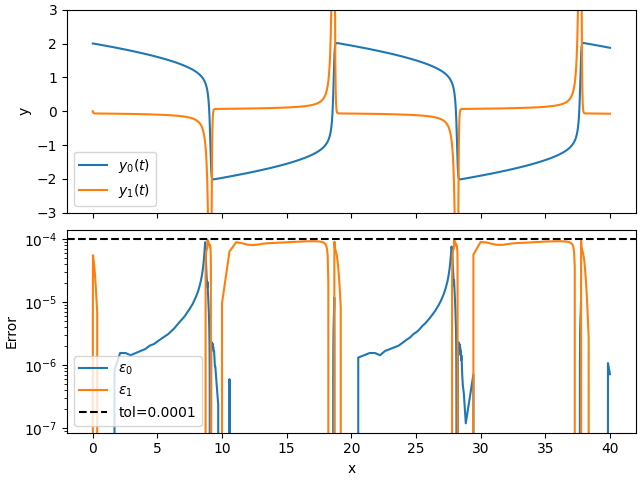

In [5]:
fig, ax = plt.subplots(2, 1,sharex=True, layout='constrained')
ax[0].plot(t_vals_ro32, y_vals_ro32, '-', label=[f'$y_{i}(t)$' for i in range(2)])
ax[0].set_ylim(-3,3)
ax[0].set_ylabel('y')
ax[0].legend()

ax[1].plot(t_vals_ro32, err_vals_ro32, '-', label=[f'$\epsilon_{i}$' for i in range(2)])
ax[1].axhline(tol, color='k', linestyle='--', label='tol={}'.format(tol))
ax[1].set_yscale('log')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')
ax[1].legend()